# FEE simple study

Study of performance of the "simple" FEE model of the PMT FE electronics

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [5]:
import system_of_units as units

In [6]:
import time

In [60]:
import FEE 

In [149]:
import tables

In [155]:
import mplFunctions as mpl
import wfmFunctions as wfm

## Revised on:

In [80]:
print(time.strftime("%d/%m/%Y"))

25/10/2016


In [81]:
print(time.strftime("%H:%M:%S"))

22:31:33


In [110]:
!pep8 ../Sierpe/FEE.py

In [111]:
!pyflakes ../Sierpe/FEE.py

# Definitions and Data

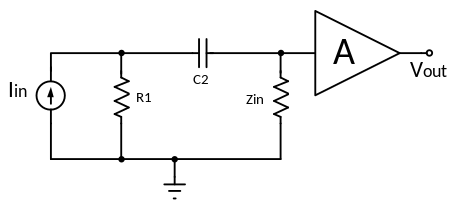

In [7]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_simple.png")

The circuit in figure representss a simple model of the fron-end electronics of the energy plane (FEE). C2 is the  capacitor that decouples the PMT signal from DC. R1 is a large resistor to ground and Z1 is the equivalent impedance of the system. A high pass filter (HPF) originates from 1/(RC), where C = C2 and R:

\begin{equation}
    R = R_1 + Z_{in}
\end{equation}

The amplifier is design to act as a low pass filter (LPF). It is modelled as the convolution of an order 1 LPF and an order 4 LPF.

The front end electronics is modelled by class SimpleFee, and the DAQ by class SimpleDAQ

### SimpleFee 

SimpleFee is a class (designed as a simple type, e.g, a data container) holding relevant information to describe the PMT front-end electronics, including the electronics gain, the value of capacitor C2, resistor R1 and impedance Zin (see above), and the values of the LPF associated to the shaping amplifier.

#### SimpleFee instance 

In [19]:
sfe = FEE.SimpleFee(gain=582.2*units.ohm, C2=8*units.nF, R1=1567*units.ohm, Zin=62*units.ohm, 
                 f_sample=1./(25*units.ns), f_LPF1=3E6*units.hertz, f_LPF2=10E6*units.hertz,
                 noise_rms=0.3*units.mV)

In [20]:
sfe


        (C2 =     8.0 nf, R1 =  1567.0 ohm, Zin =    62.0 ohm,
         gain =   582.2 ohm, f_sample =    40.0 MH,
         self.freq_HPF =   12.21 kHz, self.freq_LPF1 =    3.00 MHZ,
         self.freq_LPF2 =   10.00 MHZ,
         self.freq_HPFd =  0.00061  self.freq_LPF1d =    0.15
         self.freq_LPF2d =    0.50,
         noise_rms =    0.30 mV)
        

### SimpleDAQ

SimpleDAQ is a container class describing the data acquisition (for this simplified version it simply provides the conversion votsToADC)

#### SimpleDAQ instance

In [24]:
sdaq = FEE.SimpleDAQ( nbits=12)

In [25]:
sdaq


        (NIBTS = 12, LSB = 0.00049 volts/adc, volts to adc = 0.00039)
        

### SPE

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

#### SPE instance

In [55]:
spe = FEE.SPE(sfe)

In [56]:
spe


        (PMT gain = 4.5e+06, slope =  5.00 ns, flat =  1.00 ns)
        

### SPE functions

1. spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns): generates a spe pulse between t0 and tmax in units of t_step
2. def spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, time_step=1*units.ns): 
   generates a train of spe pulses between signal_start and (start+ length), in the window daq_window
   
3. spe_pulse_from_vector(spe,cnt): Returns a train of SPE pulses corresponding to vector cnt

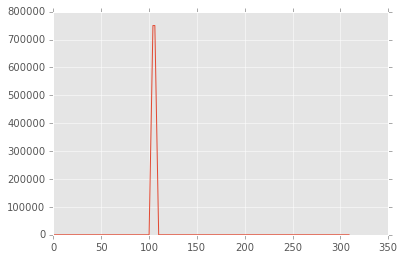

In [65]:
plt.plot(FEE.spe_pulse(spe,t0=100*units.ns, tmax=300*units.ns))

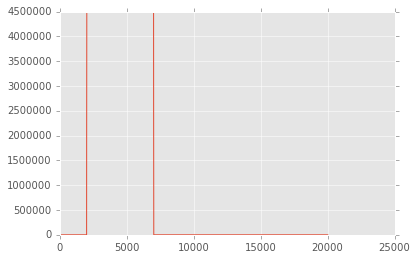

In [66]:
plt.plot(FEE.spe_pulse_train(spe,signal_start=2000*units.ns,signal_length=5000*units.ns, daq_window=20*units.mus))

In [67]:
cnt = np.random.poisson(5, 10000)

In [78]:
len(spe.spe)

11

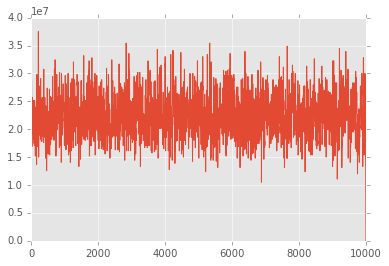

In [79]:
plt.plot(FEE.spe_pulse_from_vector(spe,cnt))

### FEE functions

1. i_to_adc(sfe,sdaq): conversion from current to adc counts
2. i_to_v(sfe): conversion from current to voltage
3. noise_adc(sfe,sdaq): noise outuput in adc counts

In [30]:
FEE.i_to_adc(sfe,sdaq)*100*units.muA

0.00014904319999999998

In [32]:
FEE.i_to_v(sfe)*units.muA/units.mV

0.5821999999999998

In [33]:
FEE.noise_adc(sfe, sdaq)

0.768

In [49]:
spe.pmt_gain

4500000.0

### Modeling FEE as the convolution of HPF and LPF filters

1. filter_fee(sfe): returns the parameter of the digital filter that represents the FEE electronics (.eg, the convolution of the HPF and the two LPD)
2. filter_fee_lpf(sfe): returns the parameters of the digital filter that represents an ideal electronic where deconvolution would be perfect (e.g, convolution of the LPF filters, not HPF). 
3. filter_fee_hpf(sfe): returns the parameters of the digital filter that represents only the HPF).

In [86]:
b,a = FEE.filter_fee(sfe)

In [87]:
print(a,b/units.ohm)

(array([ 1.        , -1.61088427,  1.09765517, -0.78293618,  0.31493283,
       -0.02845595,  0.01080426]), array([ 10.58277784,  42.33111137,  52.91388922,   0.        ,
       -52.91388922, -42.33111137, -10.58277784]))


In [90]:
def plot_filter(sfe):
    """
    plots the filter
    """
    b,a = FEE.filter_fee(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_HPFd, color='green') # cutoff frequency
    plt.show()

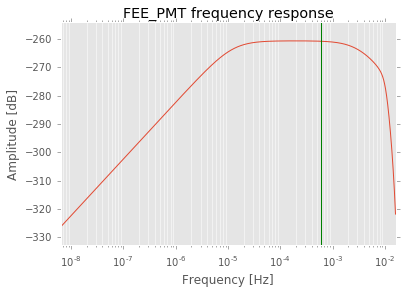

In [91]:
plot_filter(sfe)

In [106]:
def plot_filter_lpf(sfe):
    """
    plots the lpf filter
    """
    b,a = FEE.filter_fee_lpf(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_LPF1d, color='green') # cutoff frequency
    plt.show()

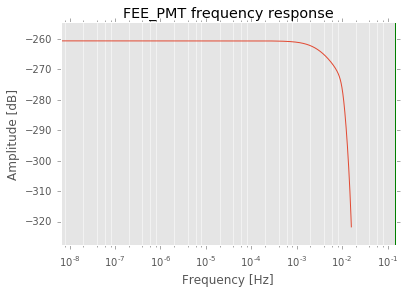

In [107]:
plot_filter_lpf(sfe)

In [108]:
def plot_filter_hpf(sfe):
    """
    plots the lpf filter
    """
    b,a = FEE.filter_fee_hpf(sfe)
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000)) 
    plt.figure(2)
    plt.semilogx(w*sfe.f_sample/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(sfe.freq_HPFd, color='green') # cutoff frequency
    plt.show()

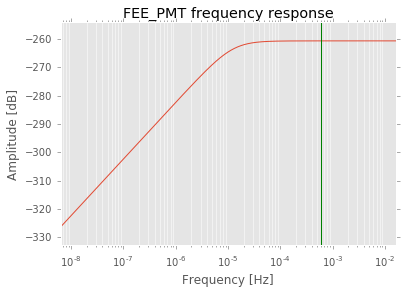

In [109]:
plot_filter_hpf(sfe)

### Effect of the FEE

1. signal_fee(sfe,signal_in): takes an instance of sfe and a signal and returns the output of the full FEE (convolution of HPF and LPF filters)
2. signal_fee_lpf(sfe,signal_in): Same, but the output is the effect of LPF filters only
3. signal_fee_hpf(sfe,signal_in): Same, but the output is the effect of HPF filters only


### Effect of FEE in a square signal

#### Generate a square signal as a train of SPE

In [113]:
signal_PE = FEE.spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus)

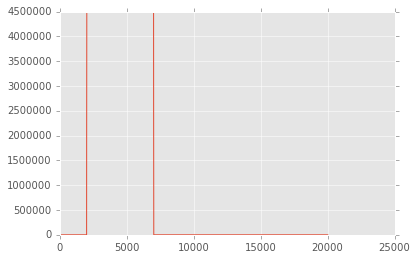

In [114]:
plt.plot(signal_PE)

#### Effect of the full FEE (LPF + HPF)

In [115]:
sgn_fee =FEE.signal_fee(sfe,signal_PE)

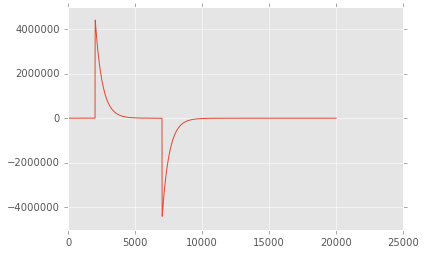

In [116]:
plt.plot(sgn_fee)

#### LPF

In [118]:
sgn_fee_lpf =FEE.signal_fee_lpf(sfe,signal_PE)

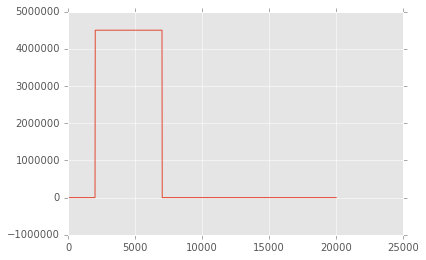

In [119]:
plt.plot(sgn_fee_lpf)

#### HPF

In [120]:
sgn_fee_hpf =FEE.signal_fee_hpf(sfe,signal_PE)

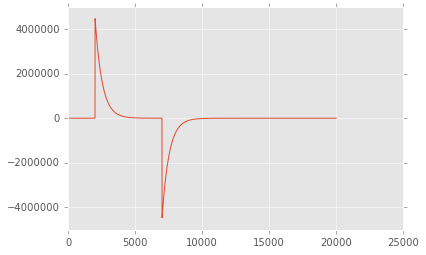

In [121]:
plt.plot(sgn_fee_hpf)

#### NB: the effect of the LPF appears negligible in a square signal. 

In [122]:
def signal_area_r2(signal_in, signal_filt):
    r_in_lpf = np.sum(signal_in)/np.sum(signal_filt)
    print('signal_in/signal_filt = {} '.format(r_in_lpf))

In [123]:
signal_area_r2(signal_PE, sgn_fee_lpf)

signal_in/signal_filt = 1.0 


In [124]:
signal_area_r2(signal_PE, sgn_fee_hpf)

signal_in/signal_filt = 6.5485001268e+11 


### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [125]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [126]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

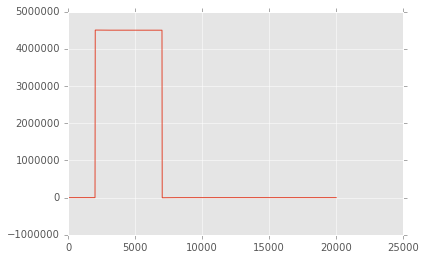

In [127]:
plt.plot(signal_r)

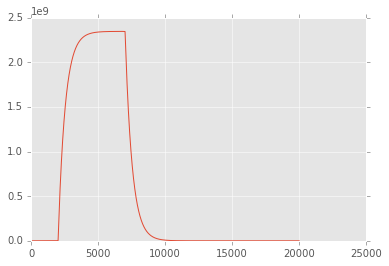

In [128]:
plt.plot(acum)

### Ideal case: perfect deconvolution

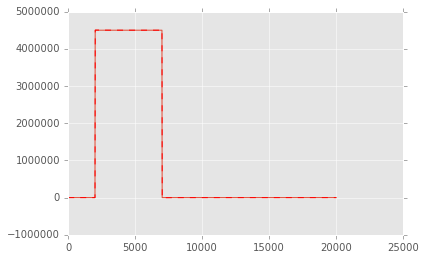

In [129]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'r--', linewidth=1)
plt.show()

In [130]:
def signal_area_ratio(signal_in, signal_lpf, signal_r):
    r_in_lpf = np.sum(signal_in)/np.sum(signal_lpf)
    r_in_r = np.sum(signal_in)/np.sum(signal_r)
    print('signal_in/signal_lpf = {} signal_in/signal_r = {}'.format(r_in_lpf, r_in_r))

In [131]:
signal_area_ratio(signal_PE, sgn_fee_lpf, signal_r)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 1.00000030667


### Convolution/Deconv for short signals

In [133]:
signal_PE = FEE.spe_pulse(spe,t0=100*units.ns, tmax=500*units.ns)

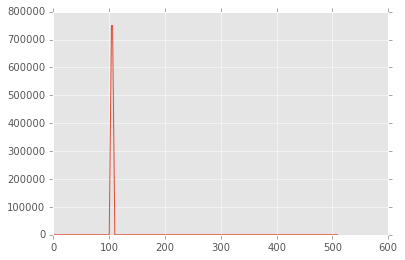

In [134]:
plt.plot(signal_PE)

In [135]:
sgn_fee_lpf = FEE.signal_fee_lpf(sfe,signal_PE)

In [136]:
sgn_fee = FEE.signal_fee(sfe,signal_PE)

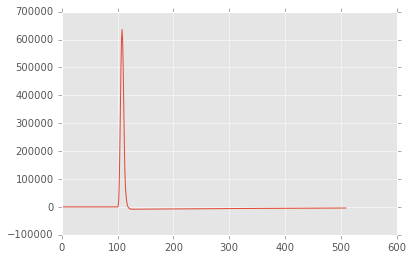

In [137]:
plt.plot(sgn_fee)

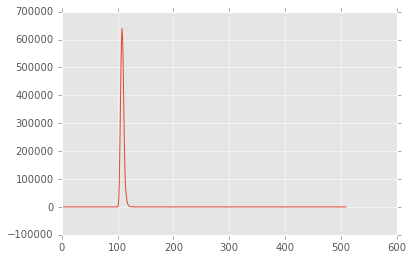

In [138]:
plt.plot(sgn_fee_lpf)

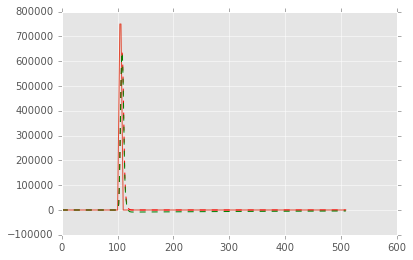

In [139]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_PE)),sgn_fee_lpf,'r--', linewidth=1)
plt.plot(np.arange(len(signal_PE)),sgn_fee,'g--', linewidth=1)
plt.show()

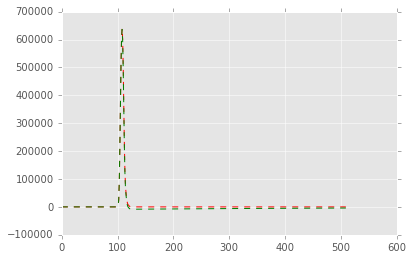

In [140]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),sgn_fee_lpf,'r--', linewidth=1)
plt.plot(np.arange(len(signal_PE)),sgn_fee,'g--', linewidth=1)
plt.show()

In [141]:
signal_area_ratio(signal_PE, sgn_fee_lpf, sgn_fee)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 2.15859415681


#### Deconvolution

In [142]:
signal_r, acum = deconv_simple(sgn_fee,coef=sfe.freq_HPFd*np.pi)

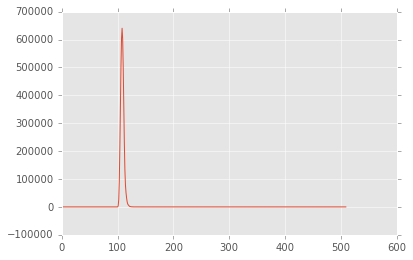

In [143]:
plt.plot(signal_r)

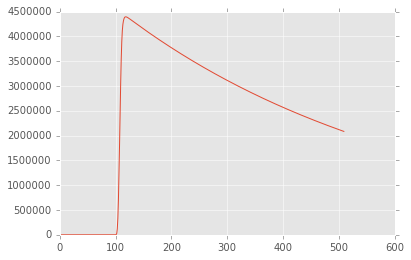

In [144]:
plt.plot(acum)

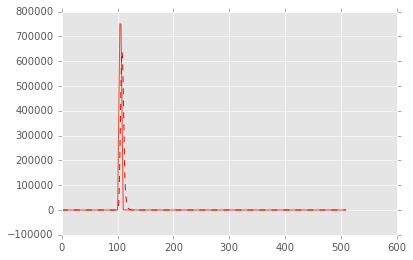

In [145]:
plt.figure(1)
plt.plot(np.arange(len(signal_PE)),signal_PE)
plt.plot(np.arange(len(signal_r)),signal_r,'r--', linewidth=1)
plt.show()

#### NB: the deconvolution algorithm deconvolves the HPF, but the effect of the LPF, which is invisible in long signals appears evident in the single photoelectron pulse.

In [146]:
signal_area_ratio(signal_PE, sgn_fee_lpf, signal_r)

signal_in/signal_lpf = 1.0 signal_in/signal_r = 0.999556008994


## Reading short (Kripton signals)

#### List the files

In [147]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5


#### Open and inspect file

In [150]:
h5f = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5','r+')

In [151]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 800), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(8159,), zl

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [152]:
pmtrd = h5f.root.pmtrd

#### Plot pmtrd for the first event, first PMT

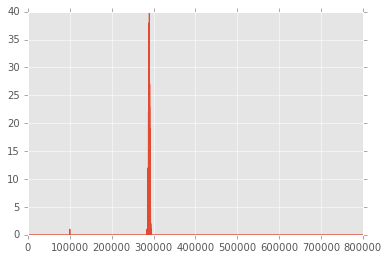

In [153]:
plt.plot(pmtrd[0,0])

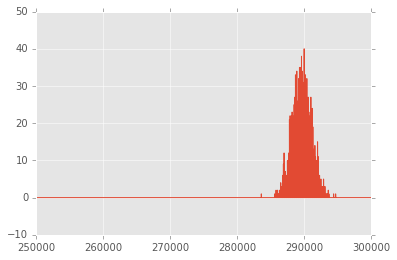

In [158]:
mpl.plts(pmtrd[0,0], signal_start=250000, signal_end=300000, offset=10)

### Convolve with the FEE

In [159]:
pmtrwf = FEE.signal_fee(sfe,pmtrd[0,0])

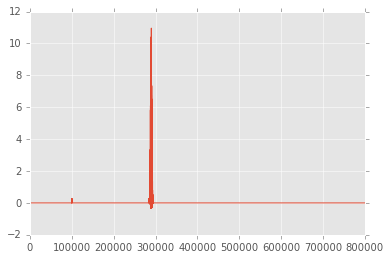

In [160]:
plt.plot(pmtrwf)

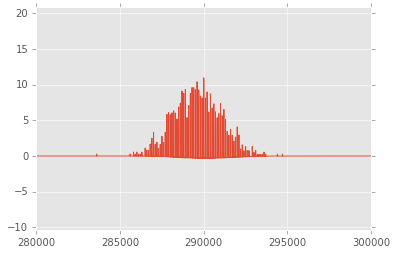

In [162]:
mpl.plts(pmtrwf, signal_start=280000, signal_end=300000, offset=10)

#### NB: With the new parameters the effect of the electronics in the short kripton signals appears small!

In [163]:
h5f_tl = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5','r+')

### Access PMT data and convolve with FEE